![](https://i.pinimg.com/564x/f9/ae/ef/f9aeef0f646f4711bfaf5d837f8766e2.jpg)

# Extended Kalman Filter

Kevin J. Walchko, Phd

21 June 2020

---

### Model

$$
\dot x(t) = f(x(t), u(t)) + w(t) \quad w(t) \sim \mathcal{N}(0,Q(t))\\
z(t) = h(x(t)) + v(t) \quad v(t) \sim \mathcal{N}(0,R(t))
$$

### Initialize

$$
\hat x(t_0) = E[x(t_x)] \\
P(t_0) = Var[x(t_0)]
$$

### Predict-Update

$$
\dot{\hat x}(t) = f(\hat x(t), u(t)) + K(t)(z(t)-h(\hat x(t))) \\
\dot P(t)=F(t)P(t)+P(t)F(t)^T-K(t)H(t)P(t)+Q(t) \\
K(t)=P(t)H(t)^T R(t)^{-1} \\
F(t)=\frac{\partial f}{\partial x} \Bigr|_{\hat x(t), u(t)} \\
H(t)=\frac{\partial h}{\partial x} \Bigr|_{\hat x(t)}
$$

## References

- [Extended Kalman Filter](https://en.wikipedia.org/wiki/Extended_Kalman_filter)

In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
import numpy as np
from numpy.testing import assert_allclose
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
from math import pi, sin, cos, atan2, asin, acos

%matplotlib inline
from matplotlib import pyplot as plt

from the_collector import BagIt, Pickle

from squaternion import Quaternion

In [67]:
deg2rad = pi/180
rad2deg = 180/pi

In [400]:
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')
        
bag = BagIt(Pickle)
data = bag.read("sim.pickle.bag")
bag_info(data)

>> Reading[pickle]: sim.pickle.bag
Bag keys:
--------------------------------------------------
       truth: 100    
        meas: 100    


In [430]:
truth = np.array(data["truth"])
meas = np.array(data["meas"])

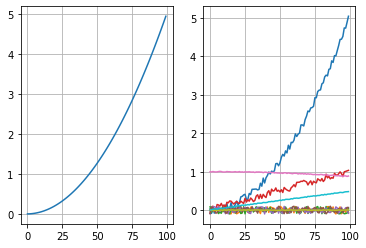

In [431]:
plt.subplot(1,2,1); plt.plot(truth[:,0]); plt.grid(True)
plt.subplot(1,2,2); plt.plot(meas); plt.grid(True)

In [68]:
import attr

@attr.s(slots=True)
class Jacobian:
    f=attr.ib() # function
    
    # cache some variables to save processing time
    n=attr.ib(init=False, default=None)
    jac=attr.ib(init=False, default=None)
    
    
@attr.s(slots=True)
class JacobianForward(Jacobian):
    def __call__(self, x, dx=1e-8):
        if self.n is None:
            self.n = len(x)
            self.jac = np.zeros((self.n, self.n))
        func = self.f(x)
        
        for j in range(self.n):
            Dxj = (abs(x[j])*dx if x[j] != 0 else dx)
            d = np.zeros(self.n)
            d[j] = Dxj
            self.jac[:, j] = (self.f(x+d) - func)/Dxj
        return self.jac
    
    
@attr.s(slots=True)
class JacobianCenter(Jacobian):
    def __call__(self, x, dx=1e-8):
        if self.n is None:
            self.n = len(x)
            self.jac = np.zeros((self.n, self.n))
        for j in range(self.n):
            Dxj = (abs(x[j])*dx if x[j] != 0 else dx)
            d = np.zeros(self.n)
            d[j] = Dxj
            self.jac[:, j] = (self.f(x+d) - self.f(x-d))/(2*Dxj)
        return self.jac
    

In [426]:
class EKF:
    def __init__(self, dt):
        """
        v=[
            p[0:2]
            v[3:5]
            q[6:9]
        ] - 10
        """
        self.J = JacobianCenter(self.func)
        self.dt = dt
        
    def func(self, x, u=None):
        if u is None:
            u = np.zeros(6)
            
        p = x[:3] + x[3:6]*self.dt
        
        rot = np.array(Quaternion(*x[6:]).to_rot())
        g = np.array([0,0,-9.8])
        a = np.array([0.1,0,9.8])
        aa = rot.dot(a)
        v = x[3:6]+g*self.dt+aa*self.dt
        
        q = Quaternion(*x[6:])
        w = Quaternion(0,u[3],u[4],u[5])
        q = q + 0.5*w*q*self.dt
        
        xx = np.array([0,0,0, 0,0,0, q.w,q.x,q.y,q.z])
        xx[:3] = p
        xx[3:6] = v
        
        return xx
        
    def reset(self):
        n = 10
        self.R = np.eye(n)
        self.Q = np.eye(n)
        self.P = np.eye(n)
        
        p = np.array([0,0,0])
        v = np.array([0,0,0])
        q = np.array([1,0,0,0])
        
#         aa = 0.001
#         gg = 0.0001
#         ba = np.array([aa,aa,aa])
#         bg = np.array([gg,gg,gg])
        self.x = np.hstack((p,v,q))
        
    def predict(self, u):
        self.x = self.func(self.x,u)
        self.F = self.J(self.x)
        self.P = self.F.dot(self.P.dot(self.F.T))+self.Q
        
    def update(self, z):
        H = np.eye(len(self.x))
        H = np.diag([0,0,0, 1,1,1, 1,1,1,1])
        I = np.eye(len(self.x))
        
        y = z - H.dot(self.x)
        S = H.dot(self.P.dot(H.T)) + self.R
        K = self.P.dot(H.T.dot(np.linalg.inv(S)))
        x = self.x + K.dot(y)
        P = (I - K.dot(H)).dot(self.P)
        
        q = Quaternion(*self.x[6:])
        if abs(1 - q.magnitude) > 1e-6:
            q.normalize
            self.x[6] = q.w
            self.x[7] = q.x
            self.x[8] = q.y
            self.x[9] = q.z
        
        self.x = x
        self.P = P
        
        return x

In [433]:
ekf = EKF(0.1)
ekf.reset()

num = len(data["meas"])

noise = np.random.uniform(-0.001,0.001,(num,10))

p = []
save = []
ts = []
t = 0
for i in range(num):
    u = np.array([0,0,0,  0,0,0.1])
    ekf.predict(u)
    
#     meas = data["meas"][i]
    y = ekf.update(meas[i,:])
    p.append(np.trace(ekf.P))
    
    save.append(y)
    ts.append(t)
    t += ekf.dt
    
save = np.array(save)

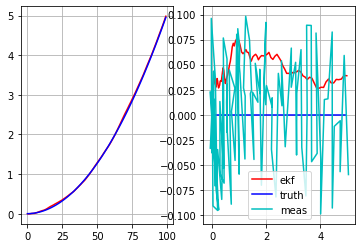

In [438]:
plt.subplot(1,2,1)
plt.plot(save[:,0],'-r',label='ekf')
plt.plot(truth[:,0],'-b',label='truth')
# plt.axis('equal')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(save[:,0],save[:,1],'-r',label='ekf')
plt.plot(truth[:,0],truth[:,1],'-b',label='truth')
plt.plot(meas[:,0],meas[:,1],'-c',label='meas')
# plt.axis('equal')
plt.grid(True)
plt.legend();

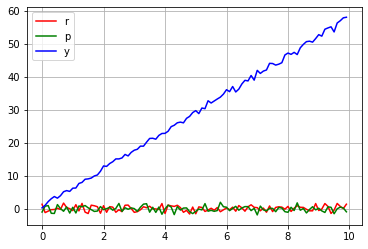

In [444]:
e = np.array([Quaternion(*x).to_euler(degrees=True) for x in save[:,-4:]])
plt.plot(ts,e[:,0],'-r',label='r')
plt.plot(ts,e[:,1],'-g',label='p')
plt.plot(ts,e[:,2],'-b',label='y')
plt.grid(True)
plt.legend();

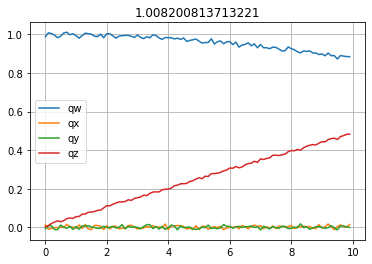

In [445]:
plt.plot(ts,save[:,6],label="qw")
plt.plot(ts,save[:,7],label="qx")
plt.plot(ts,save[:,8],label="qy")
plt.plot(ts,save[:,9],label="qz")
q = Quaternion(*save[-1,6:])
plt.title(f"{q.magnitude}")
plt.grid(True)
plt.legend();

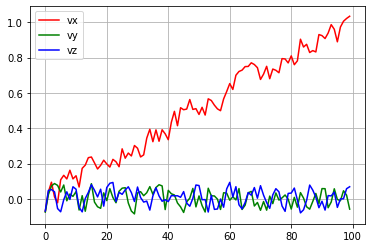

In [446]:
plt.plot(save[:,3],'-r',label='vx')
plt.plot(save[:,4],'-g',label='vy')
plt.plot(save[:,5],'-b',label='vz')
plt.grid(True)
plt.legend();